In [1]:
import time
import glob as glob
from zipfile import ZipFile
from bs4 import BeautifulSoup
import dateutil.parser as dparser
import datetime
import pandas as pd
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from sortedcontainers import SortedSet
import statistics
import operator

%matplotlib inline

In [2]:
df = pd.read_csv('/home/shane/Documents/thesis/output/final/failures.csv', parse_dates=['timestamp_dir'])
df['operational_pct'] = df['operational_pct'].astype('float') * 100
df['partial_pct'] = df['partial_pct'].astype('float') * 100
df['major_pct'] = df['major_pct'].astype('float') * 100
df['maint_pct'] = df['maint_pct'].astype('float') * 100
df

,source,service,timestamp_dir,timestamp_site,operational_count,operational_pct,partial_outage_count,partial_pct,major_outage_count,major_pct,maint_count,maint_pct
0,slack,slack,2020-03-26 12:00:01,NaN,10,100.0,0,0.0,0,0.0,0,0.0
1,slack,slack,2020-03-26 13:00:01,NaN,10,100.0,0,0.0,0,0.0,0,0.0
2,slack,slack,2020-03-26 14:00:02,NaN,10,100.0,0,0.0,0,0.0,0,0.0
3,slack,slack,2020-03-26 15:00:01,NaN,10,100.0,0,0.0,0,0.0,0,0.0
4,slack,slack,2020-03-26 16:00:01,NaN,10,100.0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
749994,cloud-google-cloud-platform,google-cloud,2020-06-10 19:00:02,NaN,1,100.0,0,0.0,0,0.0,0,0.0
749995,cloud-google-cloud-platform,google-cloud,2020-06-10 20:00:01,NaN,1,100.0,0,0.0,0,0.0,0,0.0
749996,cloud-google-cloud-platform,google-cloud,2020-06-10 21:00:01,NaN,1,100.0,0,0.0,0,0.0,0,0.0
749997,cloud-google-cloud-platform,google-cloud,2020-06-10 22:00:01,NaN,1,100.0,0,0.0,0,0.0,0,0.0


## Data validation

#### NaN counts

In [3]:
print(df.isna().sum(),'\n')
print(df.isna().sum().sum())

source                      0
service                     0
timestamp_dir               0
timestamp_site          24646
operational_count           0
operational_pct            84
partial_outage_count        0
partial_pct                84
major_outage_count          0
major_pct                  84
maint_count                 0
maint_pct                  84
dtype: int64 

24982


#### Find rows with NaN (not including timestamp_site)

In [4]:
df_tmp = df.copy()
df_tmp.drop(['timestamp_site'], axis=1, inplace=True)
is_nan = df_tmp.isnull()
row_has_nan = is_nan.any(axis=1)
nan_rows = df[row_has_nan]
nan_rows

,source,service,timestamp_dir,timestamp_site,operational_count,operational_pct,partial_outage_count,partial_pct,major_outage_count,major_pct,maint_count,maint_pct
294985,downdetector-fin-finland,snapchat,2018-09-10 00:00:02,2018-09-10T03:03:04.030439+03:00,0,NaN,0,NaN,0,NaN,0,NaN
317306,downdetector-gbr-great-britain,slack,2018-09-16 02:00:01,2018-09-16T03:01:28.474454+01:00,0,NaN,0,NaN,0,NaN,0,NaN
474662,downrightnow,netflix,2018-12-15 05:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
476529,downrightnow,hotmail,2018-12-20 02:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
476603,downrightnow,hotmail,2018-12-20 06:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
612603,downrightnow,gmail,2019-12-09 10:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
618896,downrightnow,linkedin,2019-12-25 20:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
619518,downrightnow,youtube,2019-12-27 10:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN
620036,downrightnow,gmail,2019-12-28 19:00:01,9,0,NaN,0,NaN,0,NaN,0,NaN


#### Drop timestamp_site and remaining rows with NaN

In [5]:
df.drop(['timestamp_site'], axis=1, inplace=True)
df.dropna(inplace=True)
df

,source,service,timestamp_dir,operational_count,operational_pct,partial_outage_count,partial_pct,major_outage_count,major_pct,maint_count,maint_pct
0,slack,slack,2020-03-26 12:00:01,10,100.0,0,0.0,0,0.0,0,0.0
1,slack,slack,2020-03-26 13:00:01,10,100.0,0,0.0,0,0.0,0,0.0
2,slack,slack,2020-03-26 14:00:02,10,100.0,0,0.0,0,0.0,0,0.0
3,slack,slack,2020-03-26 15:00:01,10,100.0,0,0.0,0,0.0,0,0.0
4,slack,slack,2020-03-26 16:00:01,10,100.0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
749994,cloud-google-cloud-platform,google-cloud,2020-06-10 19:00:02,1,100.0,0,0.0,0,0.0,0,0.0
749995,cloud-google-cloud-platform,google-cloud,2020-06-10 20:00:01,1,100.0,0,0.0,0,0.0,0,0.0
749996,cloud-google-cloud-platform,google-cloud,2020-06-10 21:00:01,1,100.0,0,0.0,0,0.0,0,0.0
749997,cloud-google-cloud-platform,google-cloud,2020-06-10 22:00:01,1,100.0,0,0.0,0,0.0,0,0.0


## General statistics

#### Sum and percentage of status types

In [6]:
operational_sum = df['operational_count'].sum()
partial_outage_sum = df['partial_outage_count'].sum()
major_outage_sum = df['major_outage_count'].sum()
maintenance_sum = df['maint_count'].sum()

total_sum = operational_sum + partial_outage_sum + major_outage_sum + maintenance_sum

print('operatnl sum:', operational_sum, '\tpct:', round(operational_sum/total_sum*100, 2))
print('p_outage sum:', partial_outage_sum, '\tpct:', round(partial_outage_sum/total_sum*100, 2))
print('m_outage sum:', major_outage_sum, '\tpct:', round(major_outage_sum/total_sum*100, 2))
print('maintnce sum:', maintenance_sum, '\tpct:', round(maintenance_sum/total_sum*100, 2))
df.describe()

operatnl sum: 2962914 	pct: 93.93
p_outage sum: 187281 	pct: 5.94
m_outage sum: 4179 	pct: 0.13
maintnce sum: 160 	pct: 0.01


,operational_count,operational_pct,partial_outage_count,partial_pct,major_outage_count,major_pct,maint_count,maint_pct
count,749915.00000,749915.000000,749915.000000,749915.000000,749915.000000,749915.000000,749915.000000,749915.000000
mean,3.95100,90.732560,0.249736,8.731290,0.005573,0.535163,0.000213,0.000988
std,23.07262,28.869558,1.646733,28.099751,0.082481,7.290108,0.034642,0.240099
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.00000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.00000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.00000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,238.00000,100.000000,58.000000,100.000000,13.000000,100.000000,12.000000,100.000000


#### Overall averages per source/service grouping

In [7]:
df_mean = df.groupby(['source','service']).agg(mean_op=('operational_pct',np.mean), mean_part=('partial_pct',np.mean), mean_maj=('major_pct',np.mean), mean_maint=('maint_pct',np.mean))
df_mean.describe()

,mean_op,mean_part,mean_maj,mean_maint
count,188.000000,188.000000,188.000000,188.000000
mean,86.303604,12.742754,0.951563,0.002080
std,20.543723,18.847128,3.046368,0.020606
min,29.468599,0.000000,0.000000,0.000000
25%,82.674426,0.434207,0.000000,0.000000
50%,97.353175,2.547476,0.048181,0.000000
75%,99.519289,16.819057,0.386474,0.000000
max,100.000000,61.564462,22.125604,0.275623


#### Daily/hourly averages per source/service grouping

In [8]:
df['days'] = df.timestamp_dir.dt.date
df['hours'] = df.timestamp_dir.dt.hour
df_grp = df.groupby(['source','service','days']).agg({'operational_pct': 'mean', 'partial_pct': 'mean', 'major_pct': 'mean', 'maint_pct': 'mean'})
df_grp.describe()

,operational_pct,partial_pct,major_pct,maint_pct
count,31572.000000,31572.000000,31572.000000,31572.000000
mean,90.787927,8.709433,0.501663,0.000977
std,22.907072,21.713319,4.257854,0.069768
min,0.000000,0.000000,0.000000,0.000000
25%,95.833333,0.000000,0.000000,0.000000
50%,100.000000,0.000000,0.000000,0.000000
75%,100.000000,4.166667,0.000000,0.000000
max,100.000000,100.000000,100.000000,7.692308


In [9]:
df_grp2 = df.groupby(['source','service','days','hours']).agg({'operational_pct': 'mean', 'partial_pct': 'mean', 'major_pct': 'mean', 'maint_pct': 'mean'})
df_grp2.describe()

,operational_pct,partial_pct,major_pct,maint_pct
count,745176.000000,745176.000000,745176.000000,745176.000000
mean,90.834524,8.672522,0.491960,0.000994
std,28.722324,28.009329,6.985737,0.240861
min,0.000000,0.000000,0.000000,0.000000
25%,100.000000,0.000000,0.000000,0.000000
50%,100.000000,0.000000,0.000000,0.000000
75%,100.000000,0.000000,0.000000,0.000000
max,100.000000,100.000000,100.000000,100.000000


## Figures and plots

In [10]:
sns.set(rc={'figure.figsize':(12,10)})
sns.set(style='white')

#### Boxplot and letter value plots (% services in a given state)

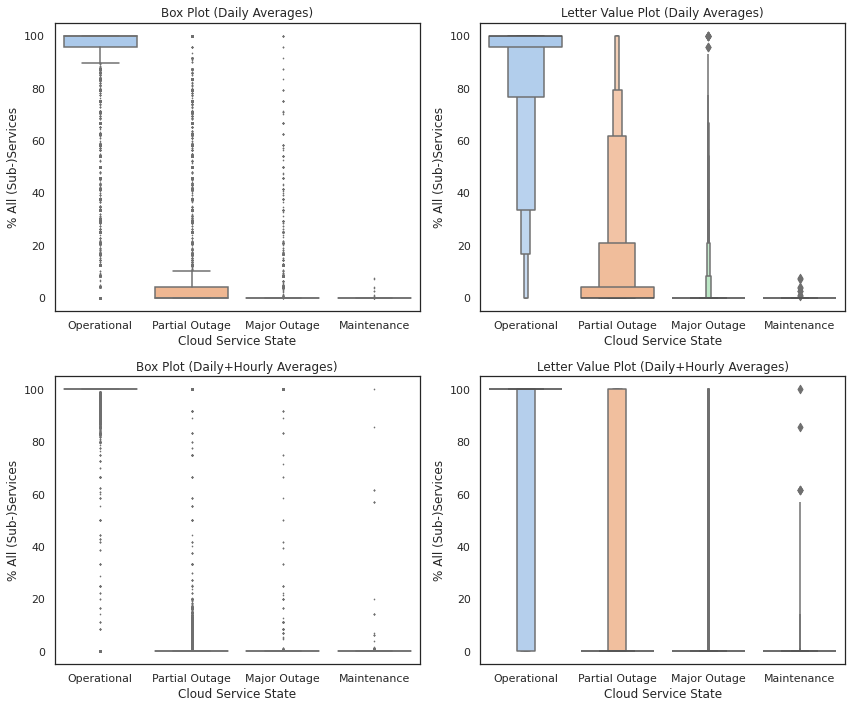

In [11]:
fig, ax = plt.subplots(2,2)
ax1 = sns.boxplot(x='variable', y='value', palette='pastel', fliersize=0.8, data=pd.melt(df_grp), ax=ax[0][0])
ax2 = sns.boxenplot(x='variable', y='value', palette='pastel', data=pd.melt(df_grp), showfliers = True, ax=ax[0][1])
ax1.set(title='Box Plot (Daily Averages)', xticklabels=['Operational','Partial Outage', 'Major Outage', 'Maintenance'], xlabel='Cloud Service State', ylabel='% All (Sub-)Services')
ax2.set(title='Letter Value Plot (Daily Averages)', xticklabels=['Operational','Partial Outage', 'Major Outage', 'Maintenance'], xlabel='Cloud Service State', ylabel='% All (Sub-)Services')
ax3 = sns.boxplot(x='variable', y='value', palette='pastel', fliersize=0.8, data=pd.melt(df_grp2), ax=ax[1][0])
ax4 = sns.boxenplot(x='variable', y='value', palette='pastel', data=pd.melt(df_grp2), showfliers = True, ax=ax[1][1])
ax3.set(title='Box Plot (Daily+Hourly Averages)', xticklabels=['Operational','Partial Outage', 'Major Outage', 'Maintenance'], xlabel='Cloud Service State', ylabel='% All (Sub-)Services')
ax4.set(title='Letter Value Plot (Daily+Hourly Averages)', xticklabels=['Operational','Partial Outage', 'Major Outage', 'Maintenance'], xlabel='Cloud Service State', ylabel='% All (Sub-)Services')
fig.tight_layout()

plt.savefig('/home/shane/Documents/thesis/output/plots/boxes_general.pdf')

#### Timeseries

In [12]:
timeseries = df_grp.reset_index().pivot(index=['days'], columns=['source', 'service'], values=['operational_pct','partial_pct','major_pct','maint_pct'])
timeseries

operational_pct                                                \
source           atlassian                                                 
service             access   bitbucket confluence  developers jira-align   
days                                                                       
2017-10-23             NaN         NaN        NaN         NaN        NaN   
2017-10-24             NaN         NaN        NaN         NaN        NaN   
2017-10-25             NaN         NaN        NaN         NaN        NaN   
2017-10-26             NaN         NaN        NaN         NaN        NaN   
2017-10-27             NaN         NaN        NaN         NaN        NaN   
...                    ...         ...        ...         ...        ...   
2020-06-06           100.0  100.000000      100.0  100.000000      100.0   
2020-06-07           100.0  100.000000      100.0  100.000000      100.0   
2020-06-08           100.0  100.000000      100.0   97.222222      100.0   
2020-06-09           100.0   99.702381      100.0   98.737374      100.0   
2020-06-10           100.0   98.511905      100.0  100.000000      100.0   

                                                                        ...  \
source                                                                  ...   
service    jira-core jira-service-desk jira-software opsgenie partners  ...   
days                                                                    ...   
2017-10-23       NaN               NaN           NaN      NaN      NaN  ...   
2017-10-24       NaN               NaN           NaN      NaN      NaN  ...   
2017-10-25       NaN               NaN           NaN      NaN      NaN  ...   
2017-10-26       NaN               NaN           NaN      NaN      NaN  ...   
2017-10-27       NaN               NaN           NaN      NaN      NaN  ...   
...              ...               ...           ...      ...      ...  ...   
2020-06-06     100.0             100.0         100.0    100.0    100.0  ...   
2020-06-07     100.0             100.0         100.0    100.0    100.0  ...   
2020-06-08     100.0             100.0         100.0    100.0    100.0  ...   
2020-06-09     100.0             100.0         100.0    100.0    100.0  ...   
2020-06-10     100.0             100.0         100.0    100.0    100.0  ...   

              maint_pct                                                        \
source     downrightnow                                                         
service            ning paypal skype tumblr twitter typepad yahoomail youtube   
days                                                                            
2017-10-23          NaN    NaN   NaN    NaN     NaN     NaN       NaN     NaN   
2017-10-24          NaN    NaN   NaN    NaN     NaN     NaN       NaN     NaN   
2017-10-25          NaN    NaN   NaN    NaN     NaN     NaN       NaN     NaN   
2017-10-26          NaN    NaN   NaN    NaN     NaN     NaN       NaN     NaN   
2017-10-27          NaN    NaN   NaN    NaN     NaN     NaN       NaN     NaN   
...                 ...    ...   ...    ...     ...     ...       ...     ...   
2020-06-06          0.0    0.0   0.0    0.0     0.0     0.0       0.0     0.0   
2020-06-07          0.0    0.0   0.0    0.0     0.0     0.0       0.0     0.0   
2020-06-08          0.0    0.0   0.0    0.0     0.0     0.0       0.0     0.0   
2020-06-09          0.0    0.0   0.0    0.0     0.0     0.0       0.0     0.0   
2020-06-10          0.0    0.0   0.0    0.0     0.0     0.0       0.0     0.0   

                                
source     github-status slack  
service           github slack  
days                            
2017-10-23           NaN   NaN  
2017-10-24           NaN   NaN  
2017-10-25           NaN   NaN  
2017-10-26           NaN   NaN  
2017-10-27           NaN   NaN  
...                  ...   ...  
2020-06-06           0.0   0.0  
2020-06-07           0.0   0.0  
2020-06-08           0.0   0.0  
2020-06-09           0.0   0.0  
2020-0

In [24]:
fig = timeseries.reset_index()
fig.plot(x = 'days', y='operational_pct', sharex=True, sharey=True, marker=".", linestyle="", markersize=5, layout = (32,6), figsize = (48, 240), subplots=True, legend=True)
plt.xlabel('Date')
plt.ylabel('% (sub-)services')
plt.tight_layout()
plt.savefig('/home/shane/Documents/thesis/output/plots/plots.pdf')

## Detailed statistics

#### Frequency of status state changes per source/service

In [14]:
df_grouped = df.groupby(['source','service'])
df_grouped.head()

,source,service,timestamp_dir,operational_count,operational_pct,partial_outage_count,partial_pct,major_outage_count,major_pct,maint_count,maint_pct,days,hours
0,slack,slack,2020-03-26 12:00:01,10,100.0,0,0.0,0,0.0,0,0.0,2020-03-26,12
1,slack,slack,2020-03-26 13:00:01,10,100.0,0,0.0,0,0.0,0,0.0,2020-03-26,13
2,slack,slack,2020-03-26 14:00:02,10,100.0,0,0.0,0,0.0,0,0.0,2020-03-26,14
3,slack,slack,2020-03-26 15:00:01,10,100.0,0,0.0,0,0.0,0,0.0,2020-03-26,15
4,slack,slack,2020-03-26 16:00:01,10,100.0,0,0.0,0,0.0,0,0.0,2020-03-26,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
727188,cloud-google-cloud-platform,google-cloud,2017-11-01 04:00:01,1,100.0,0,0.0,0,0.0,0,0.0,2017-11-01,4
727189,cloud-google-cloud-platform,google-cloud,2017-11-01 05:00:01,1,100.0,0,0.0,0,0.0,0,0.0,2017-11-01,5
727190,cloud-google-cloud-platform,google-cloud,2017-11-01 06:00:01,1,100.0,0,0.0,0,0.0,0,0.0,2017-11-01,6
727191,cloud-google-cloud-platform,google-cloud,2017-11-01 07:00:01,1,100.0,0,0.0,0,0.0,0,0.0,2017-11-01,7


#### Function to get state changes

In [15]:
def get_state_changes(what):
    state_changes = []
    for name, group in df_grouped:
        sc_ts = group[group['timestamp_dir'].diff() > datetime.timedelta(days=1)].timestamp_dir.tolist()
        sc_list = []
        
        if what == 'all':
            sc_op = group[group['operational_pct'].diff() != 0].timestamp_dir.tolist()
            sc_po = group[group['partial_pct'].diff() != 0].timestamp_dir.tolist()
            sc_mo = group[group['major_pct'].diff() != 0].timestamp_dir.tolist()
            sc_ma = group[group['maint_pct'].diff() != 0].timestamp_dir.tolist()
            sc_list = sc_op + sc_po + sc_mo + sc_ma
        elif what == 'mtbfsc_po':
            sc_po = group[group['partial_pct'].diff() > 0].timestamp_dir.tolist()
            sc_list = sc_po
        elif what == 'mtbfsc_mo':
            sc_mo = group[group['major_pct'].diff() > 0].timestamp_dir.tolist()
            sc_list = sc_mo
        elif what == 'mtbfsc_ma':
            sc_ma = group[group['maint_pct'].diff() > 0].timestamp_dir.tolist()
            sc_list = sc_ma
        elif what == 'mtbrsc_po':
            sc_po = group[group['partial_pct'].diff() < 0].timestamp_dir.tolist()
            sc_list = sc_po
        elif what == 'mtbrsc_mo':
            sc_mo = group[group['major_pct'].diff() < 0].timestamp_dir.tolist()
            sc_list = sc_mo
        elif what == 'mtbrsc_ma':
            sc_ma = group[group['maint_pct'].diff() < 0].timestamp_dir.tolist()
            sc_list = sc_ma
        
        sc_set = SortedSet(sc_list)
        state_changes.append([name, len(group), sc_set, sc_ts])
    return state_changes

#### Function to calculate mean time deltas between state changes (ignore time gaps > 1 day)

In [16]:
def get_timedeltas(state_changes):
    mtbsc_stats = []
    for group in state_changes:
        grouping = group[0]
        source = grouping[0]
        service = grouping[1]
        num_records = group[1]
        changes = group[2]
        time_gaps = group[3]
        num_changes = len(changes)-1
        mtbsc = []
        
        try:
            previous = changes.pop(0)
        except:
            mtbsc_stats.append([grouping, source, service, num_records, num_changes, round(num_changes/num_records*100,2), np.nan])

        for x in range(0, len(changes)):
            current = changes.pop(0)
            if current in time_gaps:
                previous = current
                continue
            mtbsc.append(current - previous)
            previous = current
        mtbsc_mean = pd.to_timedelta(mtbsc).mean()
        mtbsc_stats.append([grouping, source, service, num_records, num_changes, round(num_changes/num_records*100,2), mtbsc_mean])
    return mtbsc_stats

#### TODO: make a function to handle duplicate code...

In [17]:
# def build_mtbsc_col(df):
#     df_tmp = pd.DataFrame(df, columns=['grouping','source','service','records','state_changes','pct_state_changes','mean_td'])
#     df_tmp['mtbsc'] = round(df_tmp['mean_td'].dt.total_seconds() / (24 * 60 * 60), 2)
#     return(df_tmp['mtbsc'])

#### MTBSC per source/service grouping (in hours, but don't consider time gaps > 1 day in the mean)

In [18]:
mtbsc_all = get_state_changes(what='all')
mean_mtbsc_all = get_timedeltas(mtbsc_all)

df_mtbsc_all = pd.DataFrame(mean_mtbsc_all, columns=['grouping','source','service','records','state_changes','pct_state_changes','mean_td'])
df_mtbsc_all['mtbsc'] = round(df_mtbsc_all['mean_td'].dt.total_seconds() / (24 * 60 * 60), 2)

#### Mean time between {partial outage, major outage, maintenance} events (fails and repairs)

In [19]:
# FAILS
col = 'mtbfsc_po'
mtbsc_po = get_state_changes(what=col)
mean_mtbsc_po = get_timedeltas(mtbsc_po)

df_mtbsc_po = pd.DataFrame(mean_mtbsc_po, columns=['grouping','source','service','records','state_changes','pct_state_changes','mean_td'])
df_mtbsc_po[col] = round(df_mtbsc_po['mean_td'].dt.total_seconds() / (24 * 60 * 60), 2)
df_mtbsc_all[col] = df_mtbsc_po[col]

# REPAIRS
col = 'mtbrsc_po'
mtbsc_po = get_state_changes(what=col)
mean_mtbsc_po = get_timedeltas(mtbsc_po)

df_mtbsc_po = pd.DataFrame(mean_mtbsc_po, columns=['grouping','source','service','records','state_changes','pct_state_changes','mean_td'])
df_mtbsc_po[col] = round(df_mtbsc_po['mean_td'].dt.total_seconds() / (24 * 60 * 60), 2)
df_mtbsc_all[col] = df_mtbsc_po[col]

In [20]:
# FAILS
col = 'mtbfsc_mo'
mtbsc_mo = get_state_changes(what=col)
mean_mtbsc_mo = get_timedeltas(mtbsc_mo)

df_mtbsc_mo = pd.DataFrame(mean_mtbsc_mo, columns=['grouping','source','service','records','state_changes','pct_state_changes','mean_td'])
df_mtbsc_mo[col] = round(df_mtbsc_mo['mean_td'].dt.total_seconds() / (24 * 60 * 60), 2)
df_mtbsc_all[col] = df_mtbsc_mo[col]

# REPAIRS
col = 'mtbrsc_mo'
mtbsc_mo = get_state_changes(what=col)
mean_mtbsc_mo = get_timedeltas(mtbsc_mo)

df_mtbsc_mo = pd.DataFrame(mean_mtbsc_mo, columns=['grouping','source','service','records','state_changes','pct_state_changes','mean_td'])
df_mtbsc_mo[col] = round(df_mtbsc_mo['mean_td'].dt.total_seconds() / (24 * 60 * 60), 2)
df_mtbsc_all[col] = df_mtbsc_mo[col]

In [21]:
# FAILS
col = 'mtbfsc_ma'
mtbsc_ma = get_state_changes(what=col)
mean_mtbsc_ma = get_timedeltas(mtbsc_ma)

df_mtbsc_ma = pd.DataFrame(mean_mtbsc_ma, columns=['grouping','source','service','records','state_changes','pct_state_changes','mean_td'])
df_mtbsc_ma[col] = round(df_mtbsc_ma['mean_td'].dt.total_seconds() / (24 * 60 * 60), 2)
df_mtbsc_all[col] = df_mtbsc_ma[col]

#REPAIRS
col = 'mtbrsc_ma'
mtbsc_ma = get_state_changes(what=col)
mean_mtbsc_ma = get_timedeltas(mtbsc_ma)

df_mtbsc_ma = pd.DataFrame(mean_mtbsc_ma, columns=['grouping','source','service','records','state_changes','pct_state_changes','mean_td'])
df_mtbsc_ma[col] = round(df_mtbsc_ma['mean_td'].dt.total_seconds() / (24 * 60 * 60), 2)
df_mtbsc_all[col] = df_mtbsc_ma[col]

In [22]:
df_mtbsc_all.describe()

,records,state_changes,pct_state_changes,mean_td,mtbsc,mtbfsc_po,mtbrsc_po,mtbfsc_mo,mtbrsc_mo,mtbfsc_ma,mtbrsc_ma
count,188.000000,188.000000,188.000000,181,181.000000,164.000000,165.000000,64.000000,64.000000,2.000000,2.000000
mean,3988.909574,207.175532,8.222021,11 days 17:39:52.562079004,11.735856,12.138841,12.193697,22.739844,22.647031,22.480000,22.465000
std,5866.299085,422.086878,9.595333,40 days 12:45:01.584050392,40.531579,29.082614,29.435196,30.107685,30.234885,7.806459,7.827672
min,1835.000000,0.000000,0.000000,0 days 01:38:11.226708074,0.070000,0.140000,0.140000,0.170000,0.120000,16.960000,16.930000
25%,2071.000000,18.000000,0.715000,0 days 16:10:24.489795918,0.670000,1.595000,1.250000,5.097500,4.762500,19.720000,19.697500
50%,2078.000000,93.000000,3.485000,1 days 22:44:00,1.950000,3.650000,3.570000,12.370000,11.765000,22.480000,22.465000
75%,2080.250000,342.250000,16.112500,6 days 00:18:06.792452830,6.010000,10.400000,10.460000,28.020000,28.020000,25.240000,25.232500
max,23362.000000,5152.000000,61.090000,349 days 10:30:00,349.440000,298.880000,298.880000,147.770000,147.770000,28.000000,28.000000


#### Letter value plots for MTBSC

In [23]:
# fig, ax = plt.subplots(1,2)
# ax3 = sns.boxenplot(y='mean_days_td', palette='pastel', data=df_mtbsc_all, ax=ax[0])
# ax4 = sns.boxenplot(y='mean_days_td', palette='pastel', data=df_mtbsc_all, showfliers = False, ax=ax[1])
# ax3.set(xlabel='All Cloud Services', ylabel='MTBSC (Days)')
# ax4.set(xlabel='All Cloud Services', ylabel='MTBSC (Days)')
# fig.tight_layout()